In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
!pip install beautifulsoup4
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
!pip install geopy
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                       

In [24]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="pinoy_food")
    location = geolocator.geocode('201 1st Ave (at E 12th St), New York City')
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [25]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [26]:
url='https://cocl.us/new_york_dataset'
nyc_data= requests.get(url)
if nyc_data.status_code == 200:
    print('Page download successful')
else:
    print('Page download error. Error code: {}'.format(page.status_code))

Page download successful


In [27]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'NBELWT4MRM0ENEPEYM1ZPONZNKU1UVJRZGJTUI3DYH3ZBPFF' # changed my Foursquare ID
    CLIENT_SECRET = 'S4OKDGR4ACLITWZXXJSORPT3VWS4ZMOGBU3VZNYVYRTJZTSS' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

In [28]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'NBELWT4MRM0ENEPEYM1ZPONZNKU1UVJRZGJTUI3DYH3ZBPFF' # i have changed the id with ##
    CLIENT_SECRET = 'S4OKDGR4ACLITWZXXJSORPT3VWS4ZMOGBU3VZNYVYRTJZTSS' # i have changed the secret with ##
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [34]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    nyc_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        nyc_data = nyc_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return nyc_data

In [35]:
# get new york data
nyc_data=get_new_york_data()

In [36]:
nyc_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [37]:
nyc_data.shape

(306, 4)

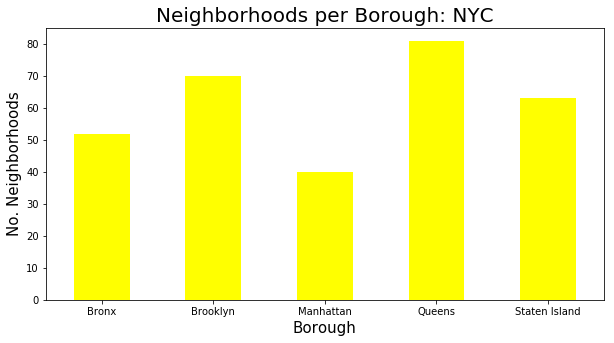

In [38]:
clr = "yellow"
nyc_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [39]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
filipino_food=pd.DataFrame(columns=column_names)
count=1
for row in nyc_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    filipino_resturants=venues[venues['Category']=='Filipino Restaurant']   
    print('(',count,'/',len(nyc_data),')','Filipino Resturants in '+Neighborhood+', '+Borough+':'+str(len(filipino_resturants)))
    print(row)
    for resturant_detail in filipino_resturants.values.tolist():
        id, name , category=resturant_detail
        filipino_food = filipino_food.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Filipino Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
done
( 2 / 306 ) Filipino Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
done
( 3 / 306 ) Filipino Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
done
( 4 / 306 ) Filipino Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
done
( 5 / 306 ) Filipino Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
done
( 6 / 306 ) Filipino Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
done
( 7 / 306 ) Filipino Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
done
( 8 / 306 ) Filipino Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
done
( 9 / 306

In [40]:
filipino_food.tail()

,Borough,Neighborhood,ID,Name
15,Staten Island,Clifton,54c43136498ee8c2a685861e,Phil-Am Kusina
16,Queens,Jamaica Hills,4c22a0bc9085d13a53af86cc,Asian Food Ltd.
17,Manhattan,Stuyvesant Town,5a73b1f49ef8ef531a1c08df,Mama Fina's
18,Manhattan,Stuyvesant Town,503f293c19a9def238a153b3,Jeepney Filipino Gastropub
19,Queens,Sunnyside Gardens,4aecab47f964a52026ca21e3,Tito Rad's Grill & Restaurant


In [41]:
filipino_food.shape

(20, 4)

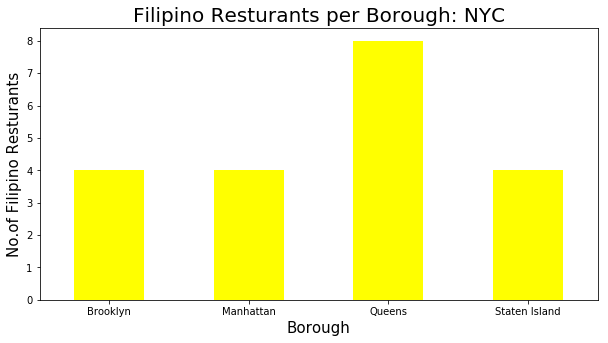

In [67]:
filipino_food.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Filipino Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Filipino Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

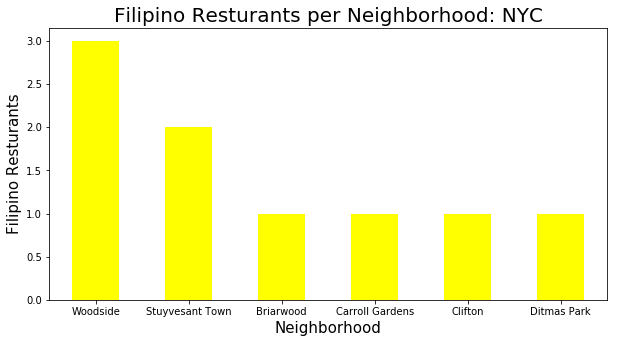

In [44]:
kainan = 6 # top number for graphing all the same past 6
filipino_food.groupby('Neighborhood')['ID'].count().nlargest(kainan).plot.bar(figsize=(10,5), color=clr)
plt.title('Filipino Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Filipino Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [45]:
filipino_food[filipino_food['Neighborhood']=='Woodside']

,Borough,Neighborhood,ID,Name
4,Queens,Woodside,4b5232def964a520456f27e3,Renee's Kitchenette & Grille
5,Queens,Woodside,4a21ab5bf964a520277d1fe3,Ihawan
6,Queens,Woodside,53040a6e498ef035406f9cbf,House of Inasal


In [50]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
filipino_stats_food=pd.DataFrame(columns=column_names)
count=1
for row in filipino_food.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(filipino_food),')','processed')
    filipino_stats_food = filipino_stats_food.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
filipino_stats_food.tail()

                         ID        Name  Likes  Rating  Tips
0  4afa2432f964a520081722e3  Purple Yam    137     7.9    76
( 1 / 20 ) processed
                         ID            Name  Likes  Rating  Tips
0  591e55677247502fb9514269  Fob Restaurant     55     7.8    28
( 2 / 20 ) processed
                         ID        Name  Likes  Rating  Tips
0  4afa2432f964a520081722e3  Purple Yam    137     7.9    76
( 3 / 20 ) processed
                         ID          Name  Likes  Rating  Tips
0  50588bc6526260483ab2860e  Pig and Khao   1081     9.1   301
( 4 / 20 ) processed
                         ID                          Name  Likes  Rating  Tips
0  4b5232def964a520456f27e3  Renee's Kitchenette & Grille     60     8.6    20
( 5 / 20 ) processed
                         ID    Name  Likes  Rating  Tips
0  4a21ab5bf964a520277d1fe3  Ihawan     94     8.4    41
( 6 / 20 ) processed
                         ID             Name  Likes  Rating  Tips
0  53040a6e498ef035406f9cbf  House o

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
15,Staten Island,Clifton,54c43136498ee8c2a685861e,Phil-Am Kusina,17,7.6,9
16,Queens,Jamaica Hills,4c22a0bc9085d13a53af86cc,Asian Food Ltd.,13,6.3,6
17,Manhattan,Stuyvesant Town,5a73b1f49ef8ef531a1c08df,Mama Fina's,44,8.2,14
18,Manhattan,Stuyvesant Town,503f293c19a9def238a153b3,Jeepney Filipino Gastropub,574,8.5,170
19,Queens,Sunnyside Gardens,4aecab47f964a52026ca21e3,Tito Rad's Grill & Restaurant,183,8.9,74


In [51]:
filipino_stats_food.shape

(20, 7)

In [52]:
filipino_stats_food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
Borough         20 non-null object
Neighborhood    20 non-null object
ID              20 non-null object
Name            20 non-null object
Likes           20 non-null object
Rating          20 non-null float64
Tips            20 non-null object
dtypes: float64(1), object(6)
memory usage: 1.2+ KB


In [53]:
filipino_stats_food.describe()

,Rating
count,20.000000
mean,7.985000
std,0.780873
min,6.300000
25%,7.600000
50%,7.900000
75%,8.525000
max,9.100000


In [55]:
# Resturant with maximum Ratings
filipino_stats_food.iloc[filipino_stats_food['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood             Lower East Side
ID              50588bc6526260483ab2860e
Name                        Pig and Khao
Likes                               1081
Rating                               9.1
Tips                                 301
Name: 3, dtype: object

In [56]:
nyc_neighborhood_stats=filipino_stats_food.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
nyc_neighborhood_stats.columns=['Neighborhood','Average Rating']
nyc_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
8,Noho,9.100000
7,Lower East Side,9.100000
15,Sunnyside Gardens,8.900000
14,Sunnyside,8.900000
13,Stuyvesant Town,8.350000
16,Woodside,8.166667
4,Elmhurst,8.000000
5,Flatbush,7.900000
10,Prospect Park South,7.900000
3,Ditmas Park,7.900000


In [57]:
nyc_borough_stats=filipino_stats_food.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
nyc_borough_stats.columns=['Borough','Average Rating']
nyc_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.7250
0,Brooklyn,7.8750
2,Queens,7.8625
3,Staten Island,7.6000


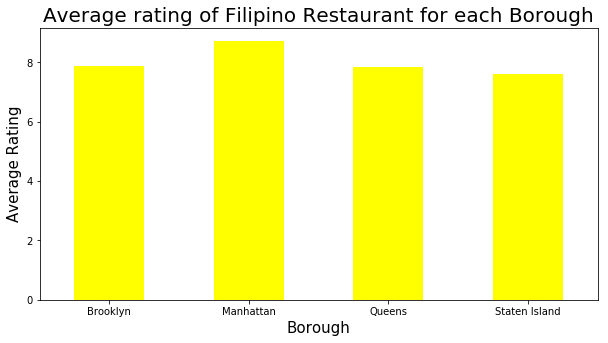

In [58]:
filipino_stats_food.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Filipino Restaurant for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [59]:
nyc_neighborhood_stats=pd.merge(nyc_neighborhood_stats,nyc_data, on='Neighborhood')
nyc_neighborhood_stats=nyc_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
nyc_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Briarwood,40.710935,-73.811748,6.300000
1,Brooklyn,Carroll Gardens,40.680540,-73.994654,7.800000
2,Staten Island,Clifton,40.619178,-74.072642,7.600000
3,Brooklyn,Ditmas Park,40.643675,-73.961013,7.900000
4,Queens,Elmhurst,40.744049,-73.881656,8.000000
5,Brooklyn,Flatbush,40.636326,-73.958401,7.900000
6,Queens,Jamaica Hills,40.711460,-73.796465,6.300000
7,Manhattan,Lower East Side,40.717807,-73.980890,9.100000
8,Manhattan,Noho,40.723259,-73.988434,9.100000
9,Staten Island,Park Hill,40.609190,-74.080157,7.600000


In [60]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode('201 1st Ave,New York City')
    latitude = 40.730610 
    longitude = -73.935242
    return latitude,longitude

In [62]:
# create map and display it
nyc_map = folium.Map(location=geo_location('New York City'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in nyc_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='orange',
            fill=True,
            fill_color='green',
            fill_opacity=0.6
        )
    )

In [66]:
nyc_neighborhood_stats['Label']=nyc_neighborhood_stats['Neighborhood']+', '+nyc_neighborhood_stats['Borough']+'('+nyc_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in nyc_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(nyc_map)        
# add incidents to map
nyc_map.add_child(incidents)